In [2]:
import os
import time
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

import model_prep_and_evals as mpe 
import A_data_sampling_workflow.sample_rasters as sr

from shapely.geometry import Polygon

import geopandas as gpd
import rioxarray as rioxr

import rasterio
from rasterio.crs import CRS

from shapely.geometry import box

import planetary_computer as pc

from skimage.feature import graycomatrix, graycoprops

from skimage.morphology import disk
from skimage.filters.rank import entropy

from scipy.ndimage import convolve as conf2D

In [3]:
box_carp = Polygon( [
            [-119.5144546684841,34.39274397377842],
            [-119.5144546684841,34.39193499538564],
            [-119.51344346289721,34.39193499538564],
            [-119.51344346289721,34.39274397377842],
            [-119.5144546684841,34.39274397377842]
          ])
itemid_carp = 'ca_m_3411936_se_11_060_20200521'

raster = sr.rioxr_from_itemid(itemid_carp, box_carp, "EPSG:4326")[:,0:150,0:150]
raster

<xarray.DataArray (band: 4, y: 150, x: 150)>
[90000 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 2.688e+05 2.688e+05 ... 2.689e+05 2.689e+05
  * y            (y) float64 3.809e+06 3.809e+06 ... 3.808e+06 3.808e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    TIFFTAG_IMAGEDESCRIPTION:  OrthoVista
    TIFFTAG_RESOLUTIONUNIT:    1 (unitless)
    TIFFTAG_SOFTWARE:          Trimble Germany GmbH
    TIFFTAG_XRESOLUTION:       1
    TIFFTAG_YRESOLUTION:       1
    scale_factor:              1.0
    add_offset:                0.0
    _FillValue:                0
    datetime:                  2020-05-21 00:00:00+00:00

In [4]:
#window_radii = [1,2,3,4,5]
window_radii = [13]
times = []

# parameters for GLCM 
distances = [1]     
angles = [0, np.pi/2] # East, North

y_len = raster.shape[1]
x_len = raster.shape[2]

buffer = 15

In [5]:
for window_r in window_radii:

    contrast = {angles[0]: np.zeros((4,y_len - buffer*2, x_len - buffer*2)), 
                angles[1]: np.zeros((4,y_len - buffer*2, x_len - buffer*2))}

    correlation = {angles[0]: np.zeros((4,y_len - buffer*2, x_len - buffer*2)), 
                   angles[1]: np.zeros((4,y_len - buffer*2, x_len - buffer*2))}

    # START TIMING
    t0 = time.time()
    for y in range(16,136):
        for x in range(16,136):
            # this window has shape (4, 2*window_r +1, 2*window_r +1)
            window = raster[:, y-window_r:y+window_r+1, x-window_r:x+window_r+1]

            for angle in angles:
                for band in range(4):
                    glcm = graycomatrix(window[band],  # can only calculate one band at a time
                                distances=distances,
                                angles=[angle])

                    # extract contrast and correlation from GLCM
                    contrast[angle][band,y-16,x-16] = graycoprops(glcm, 'contrast')[0,0]
                    correlation[angle][band,y-16,x-16] = graycoprops(glcm, 'correlation')[0,0]
    # FINISH TIMING
    times.append(time.time() - t0)
    np.savetxt('glcm_times.txt',np.array(times),fmt='%.10f')
    print('finished ', window_r)

# --------------------------
df = pd.DataFrame({'time':times, 'radius':window_radii})
#df.to_csv('times_glcm_6to13.csv', index=False)

finished  13


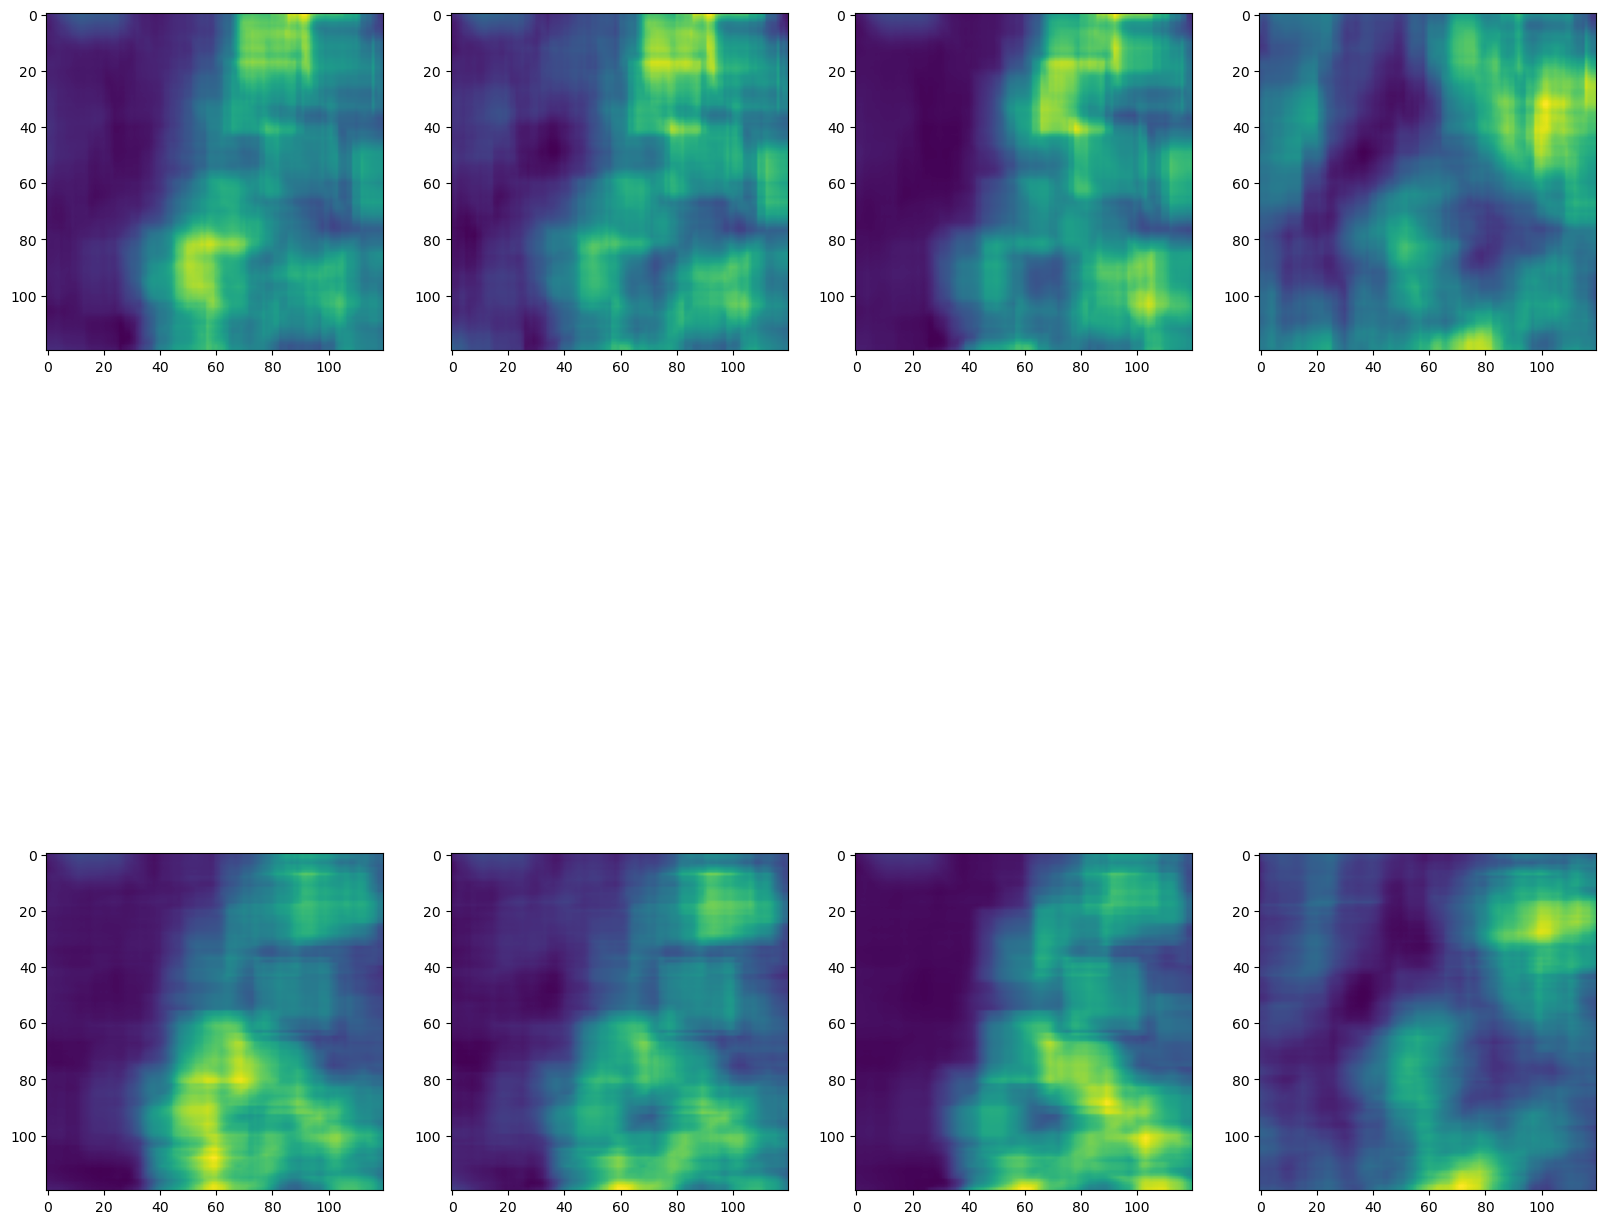

In [6]:
fig, ax = plt.subplots(2,4,figsize=(20, 20))  

for i,angle in zip(range(2),angles):
    for band in range(4):
        ax[i,band].imshow(contrast[angle][band])
plt.show()

In [12]:
df1_5 = pd.read_csv('times_glcm.csv')
df1_5

,time,radius
0,239.664772,1
1,241.804199,2
2,238.591300,3
3,239.229388,4
4,241.001430,5


In [15]:
t = [243.0685384274, 
     240.3718969822,
     240.3895251751,
     241.5010685921,
     239.9063851833,
     237.9214446545,
     237.7222869396,
     245.7115418911]

df6_13 = pd.DataFrame({'time':t, 
                       'radius' : [6,7,8,9,10,11,12,13]})

In [23]:
df_glcm = pd.concat([df1_5,df6_13]).reset_index(drop=True)
df_glcm

,time,radius
0,239.664772,1
1,241.804199,2
2,238.591300,3
3,239.229388,4
4,241.001430,5
5,243.068538,6
6,240.371897,7
7,240.389525,8
8,241.501069,9
9,239.906385,10


In [19]:
X = np.zeros((120,120))
window_r = 13
# only calculat on inner section of image (leave a margin of 15 pixels along edges)
for y in range(16,136):
    for x in range(16,136):
        # this window has shape (4, 2*window_r +1, 2*window_r +1)
        window = raster[:, y-window_r:y+window_r+1, x-window_r:x+window_r+1]

        # check that the window has desired size (no edges)
        if (window.shape[1] != 2*window_r+1) | (window.shape[2] != 2*window_r+1):
            contrast[y,x] = np.nan
            correlation[y,x] = np.nan  
        else:            

        # calculate GLCM on that small window, 
        # for a given angle, across all bands
            glcm = graycomatrix(window[0], 
                        distances=distances,
                        angles=[0])

            # extract contrast
            X[y-16,x-16] = graycoprops(glcm, 'contrast')[0,0]


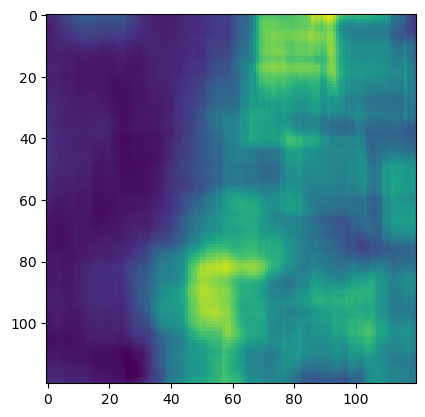

In [20]:
plt.imshow(X)
plt.show()

In [8]:
inner_raster = raster[:,16:136,16:136]
window_radii = [1,2,3,4,5,6,7,8,9,10,11,12,13]

# --------------------------------------------
# TIME AVG FEATURE CREATION
times_avg = []

for window_r in window_radii:
    box_side = window_r*2+1
    # START TIMING    
    t0 = time.time()        

    for band in range(4): 
        w = np.ones(box_side*box_side).reshape(box_side,box_side)      
        avgs = conf2D(inner_raster[band], 
                 weights=w,
                 mode='constant', # how the input array is extended beyond its boundaries
                 output='int64')
        avgs = avgs/(box_side**2)
    

    # FINISH TIMING
    times_avg.append(time.time() - t0)

    
# --------------------------------------------
# TIME ENTROPY FEATURE CREATION

times_entr = []

for window_r in window_radii:
    
    # START TIMING
    t0 = time.time()
    for band in range(4):
        entropy(inner_raster[band], disk(window_r)) 

    # FINISH TIMING
    times_entr.append(time.time() - t0)




In [9]:
df2 = pd.DataFrame({'radius': window_radii,
                    'time_avg': times_avg,
                    'time_entr': times_entr})
df2

,radius,time_avg,time_entr
0,1,0.006972,0.039789
1,2,0.005290,0.048117
2,3,0.007749,0.065104
3,4,0.010800,0.071420
4,5,0.022043,0.079256
5,6,0.025255,0.093329
6,7,0.026834,0.094491
7,8,0.033143,0.100199
8,9,0.040502,0.105889
9,10,0.059842,0.113647


In [24]:
df2['time_glcm'] = df_glcm.time
df2

,radius,time_avg,time_entr,time_glcm
0,1,0.006972,0.039789,239.664772
1,2,0.005290,0.048117,241.804199
2,3,0.007749,0.065104,238.591300
3,4,0.010800,0.071420,239.229388
4,5,0.022043,0.079256,241.001430
5,6,0.025255,0.093329,243.068538
6,7,0.026834,0.094491,240.371897
7,8,0.033143,0.100199,240.389525
8,9,0.040502,0.105889,241.501069
9,10,0.059842,0.113647,239.906385


In [26]:
df2.to_csv('texture_times.csv',index=False)